In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import matplotlib.ticker as ticker

from matplotlib.widgets import Slider
from scipy.spatial import cKDTree
from scipy.interpolate import RegularGridInterpolator
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d
from scipy.interpolate import KroghInterpolator
from scipy.integrate import quad

import h5py

In [3]:
#Cargar datos
LABELS = ["Alt_Si3N4", "Anc_Si3N4", "lambda", "n_eff", "A_eff"]

def load_and_normalize(fname):
    with h5py.File(fname, "r") as f:
        A = f["/A"][...]
    axis5 = next((ax for ax, s in enumerate(A.shape) if s == 5), None)
    if axis5 is None:
        raise ValueError(f"No encontré eje de tamaño 5 en {fname}")
    if axis5 != A.ndim - 1:
        A = np.moveaxis(A, axis5, -1)
    return A

In [4]:
archivos = [
    "Datos_reto/Datos12.h5",
    "Datos_reto/Datos13.h5"
]
datasets = [load_and_normalize(fname) for fname in archivos]

def check_borders(d1, d2):
    alt1_end = np.round(d1[-1,0,0,0],6)
    alt2_start = np.round(d2[0,0,0,0],6)
    anc1_end = np.round(d1[0,-1,0,1],6)
    anc2_start = np.round(d2[0,0,0,1],6)
    print(f"Check Alt: {alt1_end} vs {alt2_start}, Check Anc: {anc1_end} vs {anc2_start}")
    if not np.isclose(alt1_end, alt2_start) and not np.isclose(anc1_end, anc2_start):
        print("⚠️ Advertencia: los bordes no coinciden perfectamente")

for i in range(len(datasets)-1):
    check_borders(datasets[i], datasets[i+1])

DatosU = np.concatenate(datasets, axis=0)

Check Alt: 0.4 vs 0.4, Check Anc: 1.17 vs 0.6


In [5]:
with h5py.File("Datos_reto/DatosU1.h5", "w") as f_out:
    f_out.create_dataset("A", data=DatosU)

print("✅ Dataset unificado guardado en DatosU1.h5, shape:", DatosU.shape)

✅ Dataset unificado guardado en DatosU1.h5, shape: (100, 7, 7, 5)


In [6]:
def to_dataframe(arr):
    nA, nB, nC, _ = arr.shape
    rows = []
    for ii in range(nA):
        for jj in range(nB):
            for kk in range(nC):
                rec = {"i": ii+1, "j": jj+1, "k": kk+1}
                for p, name in enumerate(LABELS):
                    rec[name] = arr[ii, jj, kk, p]
                rows.append(rec)
    return pd.DataFrame(rows, columns=["i","j","k"]+LABELS)

df = to_dataframe(DatosU)
df["lambda_nm"] = df["lambda"] * 1000 
print(df)

#Guarda todos los datos en un dataframe y donde i: lambdas, j: anchuras, k: alturas


        i  j  k  Alt_Si3N4  Anc_Si3N4  lambda     n_eff         A_eff  \
0       1  1  1   0.400000       0.60    0.50  1.960858  1.505415e-13   
1       1  1  2   0.416667       0.60    0.50  1.964923  1.552818e-13   
2       1  1  3   0.433333       0.60    0.50  1.968701  1.601730e-13   
3       1  1  4   0.450000       0.60    0.50  1.972013  1.649021e-13   
4       1  1  5   0.466667       0.60    0.50  1.974902  1.695158e-13   
...   ... .. ..        ...        ...     ...       ...           ...   
4895  100  7  3   0.433333       1.17    1.57  1.620221  7.216298e-13   
4896  100  7  4   0.450000       1.17    1.57  1.630580  7.203339e-13   
4897  100  7  5   0.466667       1.17    1.57  1.640663  7.207191e-13   
4898  100  7  6   0.483333       1.17    1.57  1.650414  7.219034e-13   
4899  100  7  7   0.500000       1.17    1.57  1.659392  7.237411e-13   

      lambda_nm  
0         500.0  
1         500.0  
2         500.0  
3         500.0  
4         500.0  
...         ...

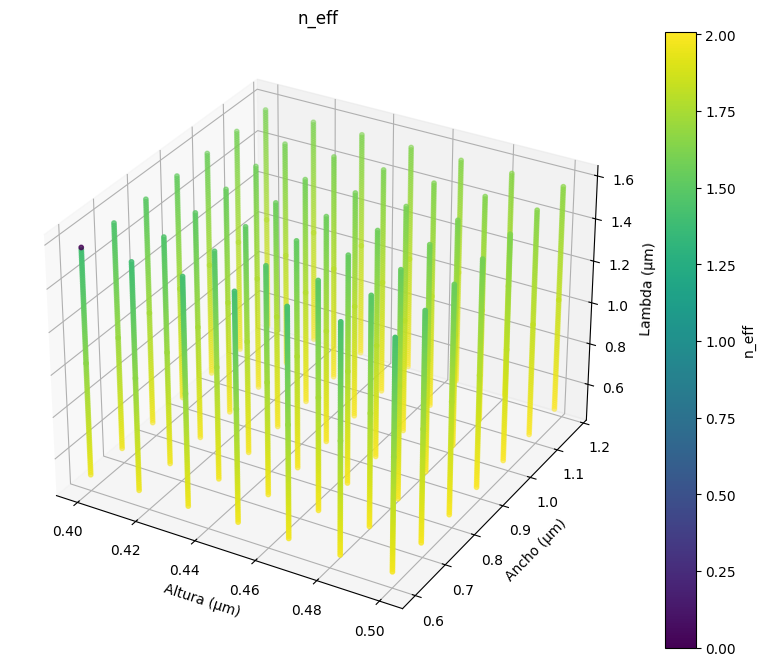

In [7]:
#Grafica N_efectivo
fig1 = plt.figure(figsize=(10,8))
ax1 = fig1.add_subplot(111, projection='3d')
p1 = ax1.scatter(df["Alt_Si3N4"], df["Anc_Si3N4"], df["lambda"],
                 c=df["n_eff"], cmap="viridis", s=10)
ax1.set_xlabel("Altura (µm)")
ax1.set_ylabel("Ancho (µm)")
ax1.set_zlabel("Lambda (µm)")
fig1.colorbar(p1, ax=ax1, label="n_eff")
ax1.set_title("n_eff")


plt.show()

Hallamos las intersecciones. Estamos interesados hallar intersecciones entre $\Delta K = 0$ y $\tau_s  = -\tau_i$

C:\Users\ekkol\AppData\Local\Temp\ipykernel_1248\998387979.py:44: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(lam_data, neff_data, grado_poly)
C:\Users\ekkol\AppData\Local\Temp\ipykernel_1248\998387979.py:44: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(lam_data, neff_data, grado_poly)
C:\Users\ekkol\AppData\Local\Temp\ipykernel_1248\998387979.py:44: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(lam_data, neff_data, grado_poly)
C:\Users\ekkol\AppData\Local\Temp\ipykernel_1248\998387979.py:44: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(lam_data, neff_data, grado_poly)


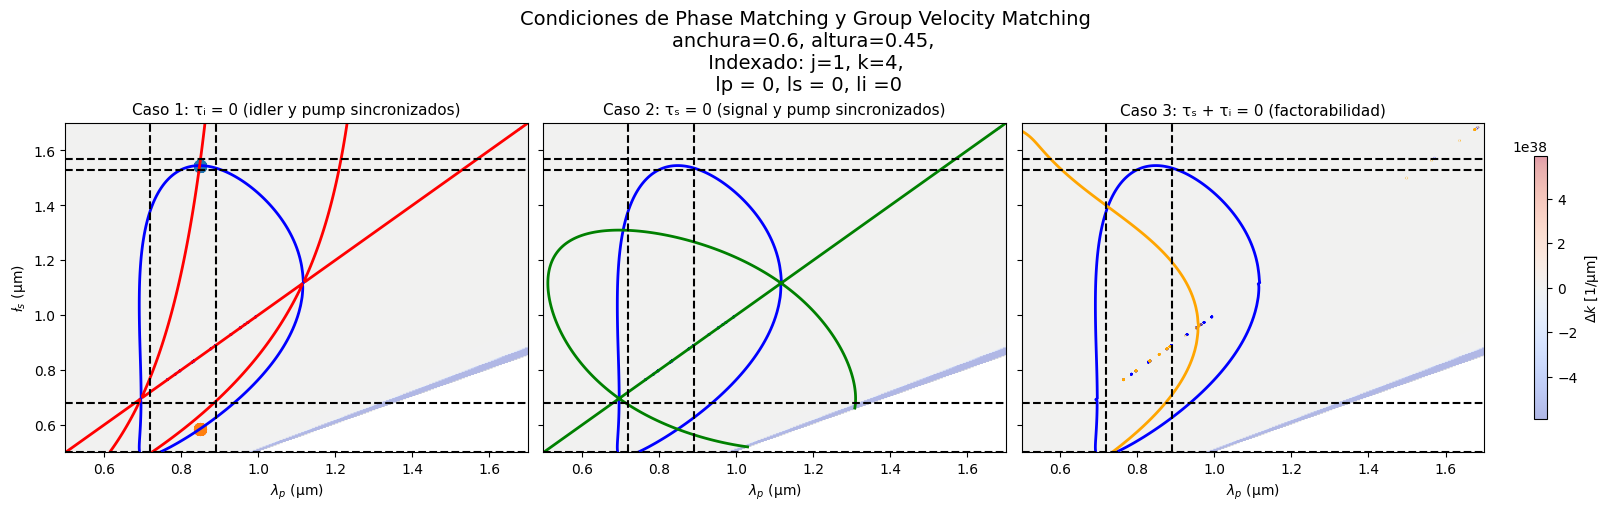

C:\Users\ekkol\AppData\Local\Temp\ipykernel_1248\998387979.py:44: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(lam_data, neff_data, grado_poly)
C:\Users\ekkol\AppData\Local\Temp\ipykernel_1248\998387979.py:44: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(lam_data, neff_data, grado_poly)
C:\Users\ekkol\AppData\Local\Temp\ipykernel_1248\998387979.py:44: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(lam_data, neff_data, grado_poly)
C:\Users\ekkol\AppData\Local\Temp\ipykernel_1248\998387979.py:44: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(lam_data, neff_data, grado_poly)
C:\Users\ekkol\AppData\Local\Temp\ipykernel_1248\998387979.py:44: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(lam_data, neff_data, grado_poly)
C:\Users\ekkol\AppData\Local\Temp\ipykernel_1248\998387979.py:44: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(lam_data, neff_data, grado_poly)
C:\U

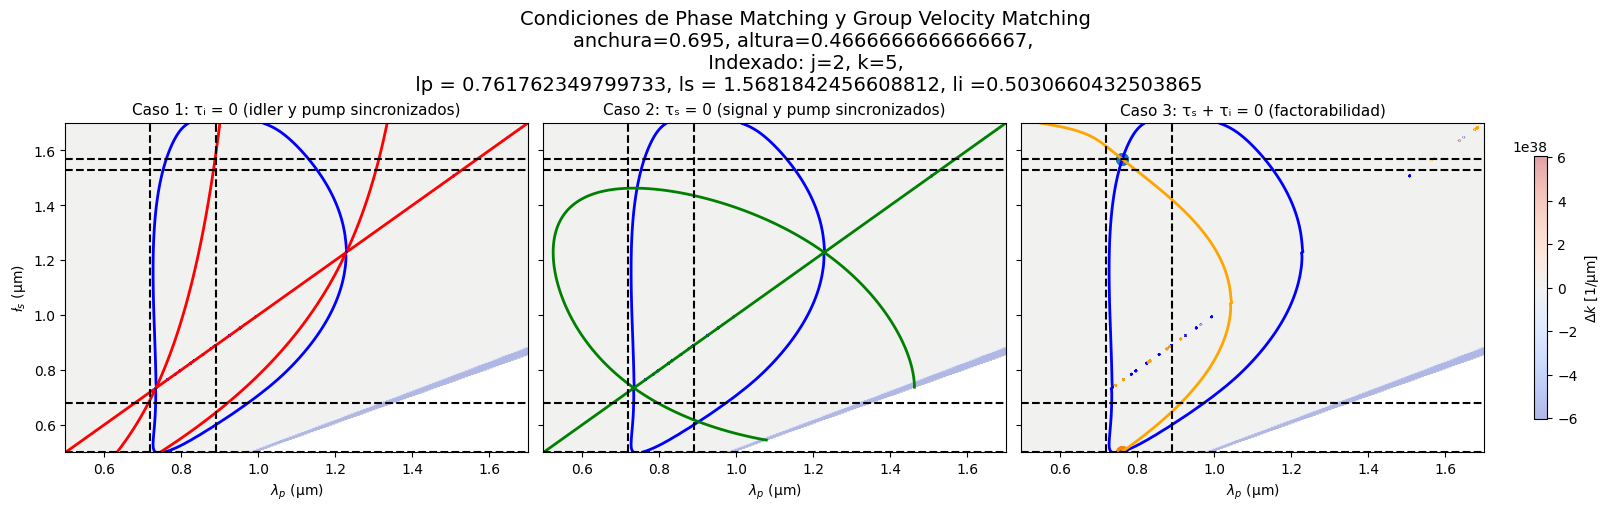

C:\Users\ekkol\AppData\Local\Temp\ipykernel_1248\998387979.py:44: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(lam_data, neff_data, grado_poly)
C:\Users\ekkol\AppData\Local\Temp\ipykernel_1248\998387979.py:44: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(lam_data, neff_data, grado_poly)
C:\Users\ekkol\AppData\Local\Temp\ipykernel_1248\998387979.py:44: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(lam_data, neff_data, grado_poly)
C:\Users\ekkol\AppData\Local\Temp\ipykernel_1248\998387979.py:44: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(lam_data, neff_data, grado_poly)
C:\Users\ekkol\AppData\Local\Temp\ipykernel_1248\998387979.py:44: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(lam_data, neff_data, grado_poly)


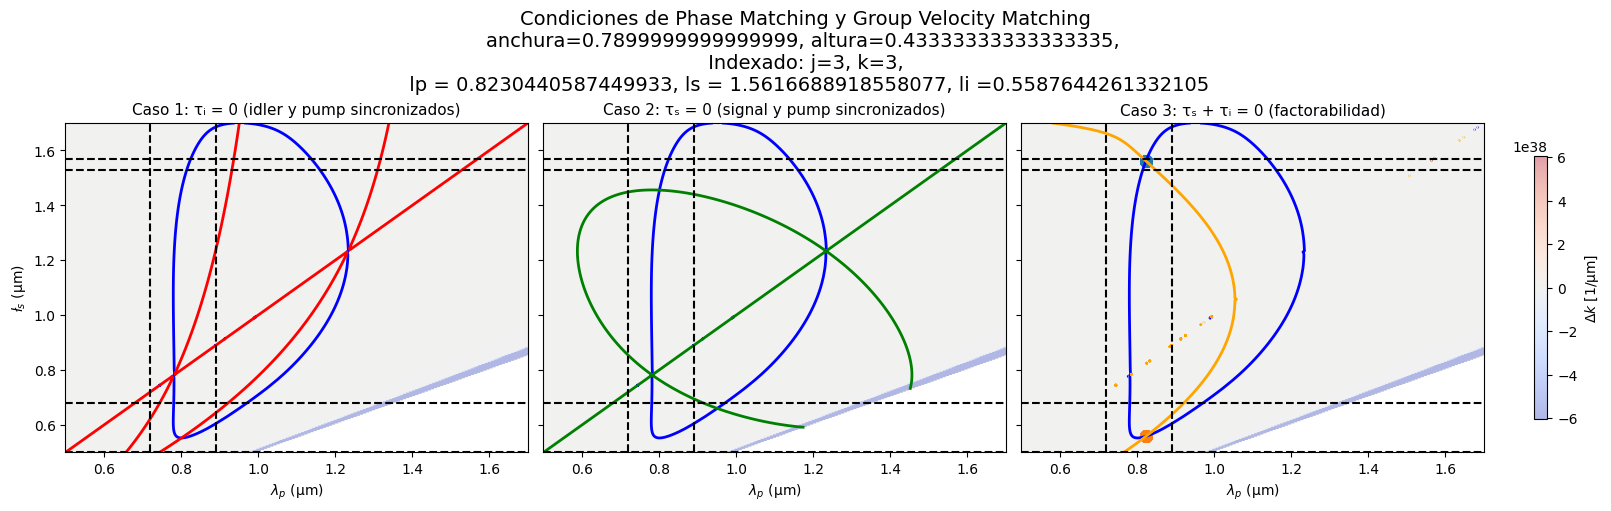

C:\Users\ekkol\AppData\Local\Temp\ipykernel_1248\998387979.py:44: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(lam_data, neff_data, grado_poly)
C:\Users\ekkol\AppData\Local\Temp\ipykernel_1248\998387979.py:44: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(lam_data, neff_data, grado_poly)


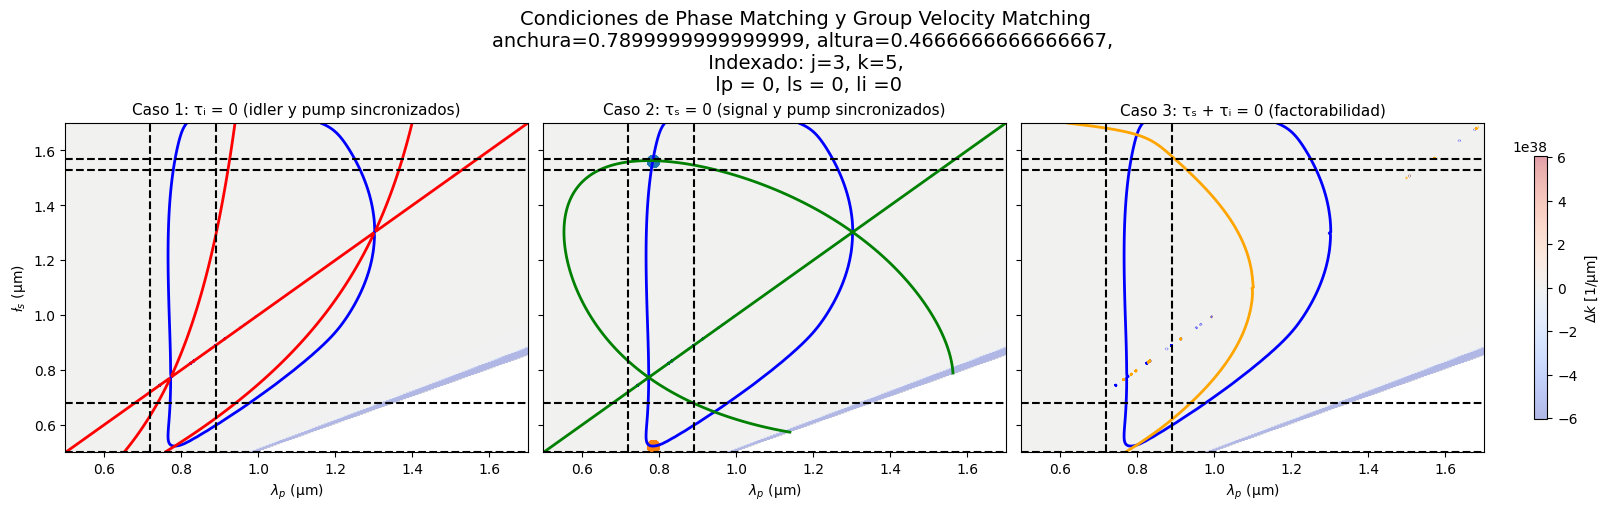

C:\Users\ekkol\AppData\Local\Temp\ipykernel_1248\998387979.py:44: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(lam_data, neff_data, grado_poly)
C:\Users\ekkol\AppData\Local\Temp\ipykernel_1248\998387979.py:44: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(lam_data, neff_data, grado_poly)
C:\Users\ekkol\AppData\Local\Temp\ipykernel_1248\998387979.py:44: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(lam_data, neff_data, grado_poly)
C:\Users\ekkol\AppData\Local\Temp\ipykernel_1248\998387979.py:44: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(lam_data, neff_data, grado_poly)
C:\Users\ekkol\AppData\Local\Temp\ipykernel_1248\998387979.py:44: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(lam_data, neff_data, grado_poly)
C:\Users\ekkol\AppData\Local\Temp\ipykernel_1248\998387979.py:44: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(lam_data, neff_data, grado_poly)
C:\U

✅ Se analizaron 4 geometrías con intersecciones.
Total de puntos de intersección encontrados: 53


In [8]:
#c = 2.99792458e14  #  micras/s
c = 1
grado_poly = 30

intersecciones = []


#Funciones generales

def neff(lam, p):
    return np.polyval(p, lam)

def neff_prime(lam, p):
    dp = np.polyder(p)
    return np.polyval(dp, lam)

def k(lam, p):
    return (2*np.pi/lam) * neff(lam, p)

def k_prime(lam, p): #Definidas sin la velocidad de la luz para evitar problemas
    return (1/c)*(neff(lam, p) - lam*(neff_prime(lam, p)))

# Búsqueda entre todas las geometrías

def fila_min_columna(mat, col): #Escoge el valor minimo en una columna y devuelve la fila y el indice de la ultima
    mat = np.array(mat)                    
    idx = np.argmin(np.abs(mat[:, col]))           
    return mat[idx], idx                  

j_vals = sorted(df["j"].unique())
k_vals = sorted(df["k"].unique())
for j_val in j_vals:
    for k_val in k_vals:
        df_geom = df[(df["j"] == j_val) & (df["k"] == k_val)]
        if df_geom.empty:
            continue  # salta combinaciones sin datos
        
        lam_data = df_geom["lambda"].values
        neff_data = df_geom["n_eff"].values
        
        #print(f"Geometría j={j_val}, k={k_val}: {len(lam)} puntos válidos")

        #Calculamos las funciones importantes
        coef = np.polyfit(lam_data, neff_data, grado_poly)
        p = np.poly1d(coef)
        
        #Generamos las combinaciones de [l_bombeo, l_signal, l_idler]. 
        lamp = np.linspace(0.72, 0.890, 750)
        lams = np.linspace(1.530, 1.570, 750)
        LAMP, LAMS = np.meshgrid(lamp, lams)
        #Restringimos lami a aquellos que cumples conservacion de energia
        LAMI_ENERGY = 1 / (2 / LAMP - 1 / LAMS)

        #Generamos una mascara de valores booleanos que nos permitan acceder a los valores correctos de LAMI_ENERGY
        mask = np.isfinite(LAMI_ENERGY) &  (LAMI_ENERGY >= 0)# (LAMI_ENERGY >= 0.5) & (LAMI_ENERGY <= 0.68)

        Kp = k(LAMP, p)
        Ks = k(LAMS, p)
        Ki = np.full_like(Kp, np.nan)# Genera una estructura de datos de igual tamaño que Kp y los rellena de np.nan
        Ki[mask] = k(LAMI_ENERGY[mask], p)# Calcula las K_lamb de los valores de LAMI validos, y Ki[mask] los inserta en las posiciones correspondientes
                                     # Esto permite que  Ki siga teniendo el mismo tamaño que antes!
        
        DK = 2 * Kp - Ks - Ki

        #Retardos de grupo
        Taus = np.full_like(Kp, np.nan)
        Taui = np.full_like(Kp, np.nan)

        Taus[mask] = k_prime(LAMP[mask], p) - k_prime(LAMS[mask], p)
        Taui[mask] = k_prime(LAMP[mask], p) - k_prime(LAMI_ENERGY[mask], p)

        #Creamos diferentes mascaras para cada condicion. Creamos un margen de error epsilon para cada una de ellas
        epsilon = 1e-4
        mask_1 = (np.abs(DK) <= epsilon)
        mask_2 = (np.abs(Taus + Taui) <= epsilon )
        mask_3 = (np.abs(Taus) <= epsilon )
        mask_4 = (np.abs(Taui) <= epsilon )

        #Intersecciones
        mask_12 = mask_1 & mask_2
        mask_13 = mask_1 & mask_3
        mask_14 = mask_1 & mask_4

        #Extraemos las combinaciones de lambdas que cumplen las condiciones especificadas a traves de una matriz donde  cada fila corresponde a un punto.
        
        def extraer_lambdas(mask_int):
            lam_p = LAMP[mask_int]
            lam_s = LAMS[mask_int]
            lam_i = LAMI_ENERGY[mask_int]
            dk = DK[mask_int]
            tau_s = Taus[mask_int]
            tau_i = Taui[mask_int]

            matriz = np.array([lam_p, lam_s, lam_i, dk, tau_s, tau_i, tau_s + tau_i])
            matriz = np.transpose(matriz)
            return matriz

        matriz_12 = extraer_lambdas(mask_12)
        matriz_13 = extraer_lambdas(mask_13)
        matriz_14 = extraer_lambdas(mask_14)

        #Integrador
        #Escogemos la fila con el numero menor entre todas las posibles intersecciones con el contorno
        fila = [0,0,0,0,0,0,0]
        indx = None
        if len(matriz_12)>0:
                fila, indx = fila_min_columna(matriz_12, len(matriz_12[0])-1)

        if (len(matriz_12) > 0) or (len(matriz_13) > 0) or (len(matriz_14) > 0):
            intersecciones.append({
                "j": j_val,
                "k": k_val,
                "puntos_12": matriz_12[indx], #Como decidimos que en indx estan los ts+ti=0 que nos interesan, escogemos esa informacion
                "puntos_13": matriz_13,
                "puntos_14": matriz_14,
                "coeficientes": p       
            })
            

            #Graficamos en todo el rango de los lambdass
            lamp = np.linspace(0.5, 1.7, 300)
            lams = np.linspace(0.5, 1.7, 300)
            LAMP, LAMS = np.meshgrid(lamp, lams)
            #Restringimos lami a aquellos que cumples conservacion de energia
            LAMI_ENERGY = 1 / (2 / LAMP - 1 / LAMS)

            #Generamos una mascara de valores booleanos que nos permitan acceder a los valores físicamente validos de lambda idler
            mask = np.isfinite(LAMI_ENERGY) & (LAMI_ENERGY >0)

            Kp = k(LAMP, p)
            Ks = k(LAMS, p)
            Ki = np.full_like(Kp, np.nan)# Genera una estructura de datos de igual tamaño que Kp y los rellena de np.nan
            Ki[mask] = k(LAMI_ENERGY[mask], p)# Calcula las K_lamb de los valores de LAMI validos, y Ki[mask] los inserta en las posiciones correspondientes
                                        # Esto permite que  Ki siga teniendo el mismo tamaño que antes!
            
            DK = 2 * Kp - Ks - Ki

            #Retardos de grupo
            Taus = np.full_like(Kp, np.nan)
            Taui = np.full_like(Kp, np.nan)

            Taus[mask] = k_prime(LAMP[mask], p) - k_prime(LAMS[mask], p)
            Taui[mask] = k_prime(LAMP[mask], p) - k_prime(LAMI_ENERGY[mask], p)

            fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True,
                                     constrained_layout=True)
            titles = [
                "Caso 1: τᵢ = 0 (idler y pump sincronizados)",
                "Caso 2: τₛ = 0 (signal y pump sincronizados)",
                "Caso 3: τₛ + τᵢ = 0 (factorabilidad)"
            ]
            colors = ['r', 'g', 'orange']
            taus_list = [Taui, Taus, Taui + Taus]

            vmax = np.nanpercentile(np.abs(DK), 99)
            vmin = -vmax

            for ax, title, color, tau, matriz in zip(axes, titles, colors, taus_list, [matriz_14, matriz_13, matriz_12]):
                matrizt = np.transpose(matriz)
                # Fondo: mapa Δk
                im = ax.imshow(DK, extent=[lamp.min(), lamp.max(), lams.min(), lams.max()],
                               origin='lower', aspect='auto', cmap='coolwarm',
                               alpha=0.4, vmin=vmin, vmax=vmax)
                # Contorno Δk = 0
                ax.contour(LAMP, LAMS, DK, levels=[0], colors='b', linewidths=2)
                # Contorno τ = 0
                ax.contour(LAMP, LAMS, tau, levels=[0], colors=color, linewidths=2)
                if len(matrizt)!=0:
                    ax.scatter(matrizt[0], matrizt[1], s=70)
                    ax.scatter(matrizt[0], matrizt[2], s=70)
                
                ax.set_title(title, fontsize=11)
                ax.set_xlabel(r'$\lambda_p$ (µm)')
                ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
                ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
                ax.axvline(x=0.72, color='black', linestyle='--')
                ax.axvline(x=0.89, color='black', linestyle='--')
                ax.axhline(y=1.53, color='black', linestyle='--')
                ax.axhline(y=1.57, color='black', linestyle='--')
                ax.axhline(y=0.5, color='black', linestyle='--')
                ax.axhline(y=0.68, color='black', linestyle='--')

            axes[0].set_ylabel(r'$\l_s$ (µm)')
            fig.colorbar(im, ax=axes, orientation='vertical', shrink=0.8,
                         label=r'$\Delta k$ [1/µm]', pad=0.02)
            fig.suptitle(
                f"Condiciones de Phase Matching y Group Velocity Matching\nanchura={df.loc[(df['j'] == j_val) & (df['k'] == k_val), 'Anc_Si3N4'].iloc[0]}, altura={df.loc[(df['j'] == j_val) & (df['k'] == k_val), 'Alt_Si3N4'].iloc[0]}, \n Indexado: j={j_val}, k={k_val}, \n lp = {fila[0]}, ls = {fila[1]}, li ={fila[2]}",
                fontsize=14
            )

            
            plt.show()


#Mostrar resumen
print(f"✅ Se analizaron {len(intersecciones)} geometrías con intersecciones.")
total_pts = sum(len(d["puntos_12"]) + len(d["puntos_13"]) + len(d["puntos_14"]) for d in intersecciones)
print(f"Total de puntos de intersección encontrados: {total_pts}")
    

Hallamos la JSA. En teoría la funcion es una integral, pero la aproximacion a primer orden de esta corresponde a la multiplicacion de la amplitud espectral de las de bombeo multiplicado por las condiciones de phase matching.

![Imagen de WhatsApp 2025-10-24 a las 19.55.36_efd03ab9.jpg](<attachment:Imagen de WhatsApp 2025-10-24 a las 19.55.36_efd03ab9.jpg>)
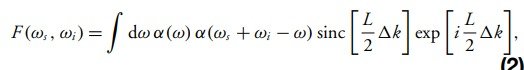

REALIZAMOS LA APROXIMACION Y LA INTEGRAL A PRIMER ORDEN

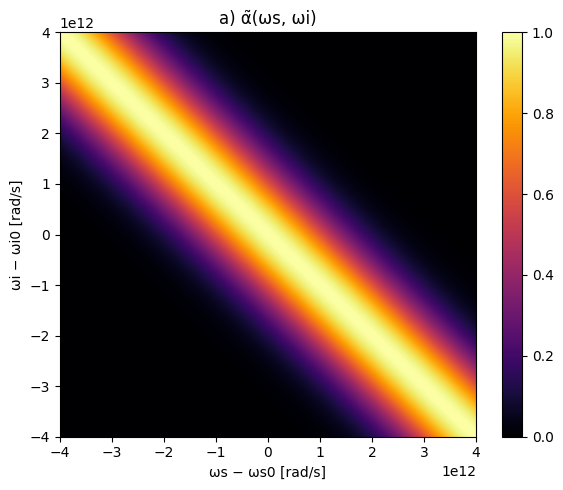

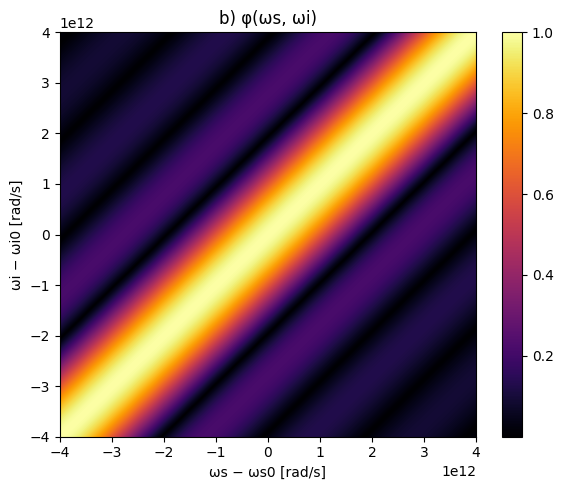

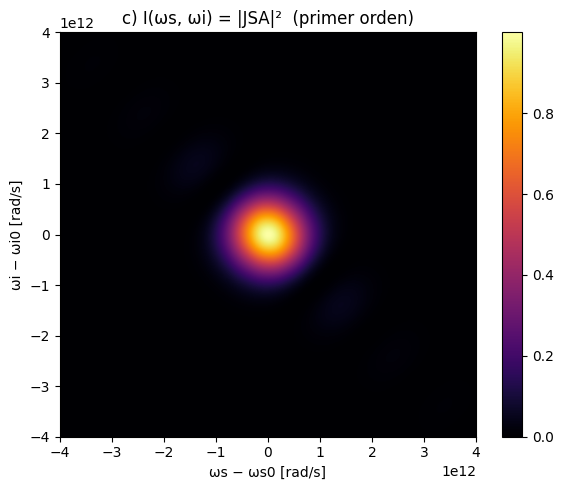

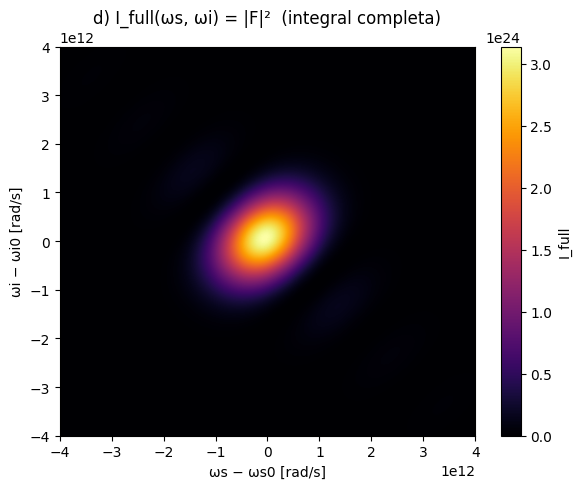

In [16]:
import numpy as np
import matplotlib.pyplot as plt


c = 2.99792458e8
sigma_p = 1e12
n = 4

punto_dict = intersecciones[2]
p = punto_dict["coeficientes"]

info = punto_dict["puntos_12"]
lambda_p0 = info[0]
lambda_s0 = info[1]
lambda_i0 = info[2]


def lam_to_omg(lam_um):
    lam_m = lam_um * 1e-6
    return 2 * np.pi * c / lam_m

def omg_to_lam(omega):
    lam_m = 2 * np.pi * c / omega
    return lam_m * 1e6   # µm

def neff_from_omega(omega, p):
    lam_um = omg_to_lam(omega)
    return np.polyval(p, lam_um)

def neff_prime_from_omega(omega, p):
    lam_um = omg_to_lam(omega)
    dp = np.polyder(p)
    dneff_dlam = np.polyval(dp, lam_um)
    dlam_domega = -2 * np.pi * c / omega**2 * 1e6
    return dneff_dlam * dlam_domega

# k(ω) Y dk/dω
def k_from_omega(omega, p):
    return neff_from_omega(omega, p) * omega / c

def k_prime_from_omega(omega, p):
    n_eff = neff_from_omega(omega, p)
    dn_domega = neff_prime_from_omega(omega, p)
    return (n_eff + omega * dn_domega) / c


# FRECUENCIAS CENTRALES
omega_p0 = lam_to_omg(lambda_p0)
omega_s0 = lam_to_omg(lambda_s0)
omega_i0 = lam_to_omg(lambda_i0)


tau_s = k_prime_from_omega(omega_p0, p) - k_prime_from_omega(omega_s0, p)
tau_i = k_prime_from_omega(omega_p0, p) - k_prime_from_omega(omega_i0, p)

L = np.sqrt(2/(0.193*(sigma_p**2)*(np.abs(tau_s*tau_i))))



delta_w = n * sigma_p

w_s = np.linspace(omega_s0 - delta_w, omega_s0 + delta_w, 400)
w_i = np.linspace(omega_i0 - delta_w, omega_i0 + delta_w, 400)

W_S, W_I = np.meshgrid(w_s, w_i)

nu_s = W_S - omega_s0
nu_i = W_I - omega_i0


# PRIMER ORDEN

def alpha_first(nu_s, nu_i, sigma):
    return np.exp(-((nu_s + nu_i) ** 2) / (2 * sigma ** 2))

def sinc(x):
    return np.sinc(x / np.pi)

def phi_first(nu_s, nu_i):
    LdK = L * (tau_s * nu_s + tau_i * nu_i)
    return sinc(LdK / 2) * np.exp(1j * LdK / 2)

A = alpha_first(nu_s, nu_i, sigma_p)
P = phi_first(nu_s, nu_i)
JSI_first = np.abs(A * P) ** 2



# INTEGRAL COMPLETA

Np = 200
omega_p = np.linspace(
    omega_p0 - 12 * sigma_p,
    omega_p0 + 12 * sigma_p,
    Np
)

ws = W_S[:, :, None]
wi = W_I[:, :, None]
wp = omega_p[None, None, :]

alpha1 = np.exp(-(wp - omega_p0) ** 2 / (2 * sigma_p ** 2))
alpha2 = np.exp(-((ws + wi - wp) - omega_p0) ** 2 / (2 * sigma_p ** 2))

# Δk(ωp, ωs, ωi)
dk = (
    k_from_omega(wp, p)
    + k_from_omega(ws + wi - wp, p)
    - k_from_omega(ws, p)
    - k_from_omega(wi, p)
)

LdK_over2 = -0.5 * L * dk
PM = np.sinc(LdK_over2/np.pi) * np.exp(1j * LdK_over2)

integrand = alpha1 * alpha2 * PM

F = np.trapezoid(integrand, omega_p, axis=2)
JSI_full = np.abs(F) ** 2


# PLOTS

extent_corr = [
    (w_s - omega_s0).min(),
    (w_s - omega_s0).max(),
    (w_i - omega_i0).min(),
    (w_i - omega_i0).max()
]

plt.figure(figsize=(6,5))
plt.imshow(A, extent=extent_corr, origin='lower', aspect='auto', cmap='inferno')
plt.title("a) α̃(ωs, ωi)")
plt.xlabel("ωs − ωs0 [rad/s]")
plt.ylabel("ωi − ωi0 [rad/s]")
plt.colorbar()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,5))
plt.imshow(np.abs(P), extent=extent_corr, origin='lower', aspect='auto', cmap='inferno')
plt.title("b) φ(ωs, ωi)")
plt.xlabel("ωs − ωs0 [rad/s]")
plt.ylabel("ωi − ωi0 [rad/s]")
plt.colorbar()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,5))
plt.imshow(JSI_first, extent=extent_corr, origin='lower', aspect='auto', cmap='inferno')
plt.title("c) I(ωs, ωi) = |JSA|²  (primer orden)")
plt.xlabel("ωs − ωs0 [rad/s]")
plt.ylabel("ωi − ωi0 [rad/s]")
plt.colorbar()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,5))
plt.imshow(JSI_full, extent=extent_corr, origin='lower', aspect='auto', cmap='inferno')
plt.title("d) I_full(ωs, ωi) = |F|²  (integral completa)")
plt.xlabel("ωs − ωs0 [rad/s]")
plt.ylabel("ωi − ωi0 [rad/s]")
plt.colorbar(label="I_full")
plt.tight_layout()
plt.show()


REALIZAMOS LA DESCOMPOSICION DE SCHMIDT


-------------------------------------
Número de Schmidt K = 1.3228747701826074
Coeficiente Primer Término =   0.8629385156514205
-------------------------------------


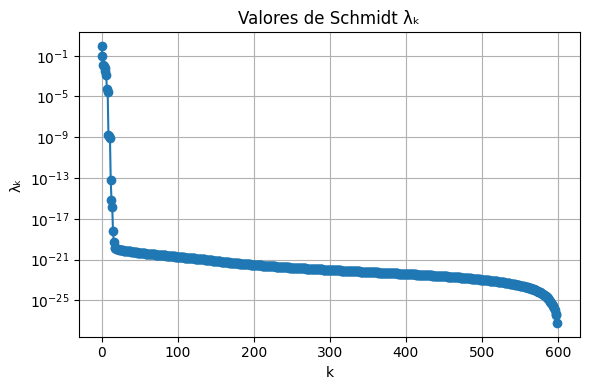

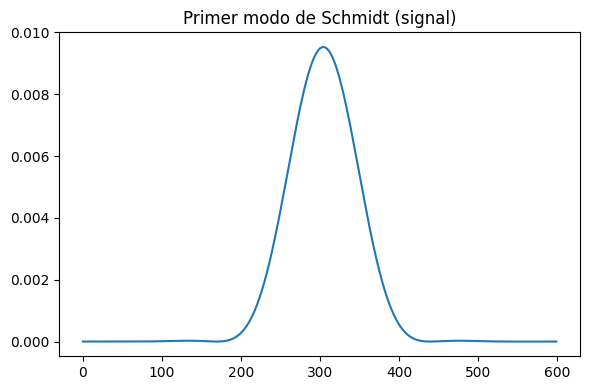

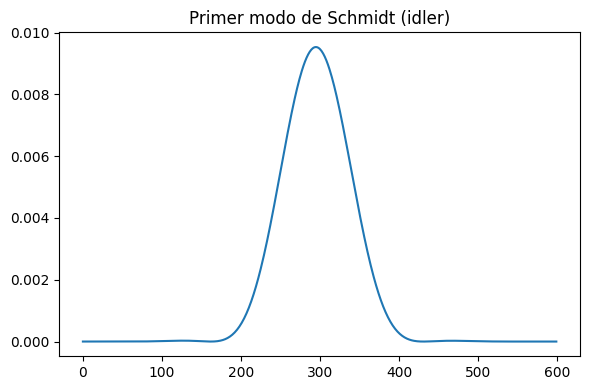

In [10]:
# NORMALIZAR LA JSA PARA SCHMIDT

JSA_full = F
norm_jsa = np.sqrt(np.sum(np.abs(JSA_full)**2))
JSA_norm = JSA_full / norm_jsa
# DESCOMPOSICIÓN DE SCHMIDT (SVD)
U, S, Vh = np.linalg.svd(JSA_norm, full_matrices=False)

# Valores de Schmidt
lambdas = S**2

# Modos (signal e idler)
u_modes = U
v_modes = Vh.conj().T

# Número de Schmidt
K = 1 / np.sum(lambdas**2)
print("\n-------------------------------------")
print("Número de Schmidt K =", K)
print("Coeficiente Primer Término =  ", lambdas[0])
print("-------------------------------------")

# GRAFICAR VALORES λ_k
plt.figure(figsize=(6,4))
plt.semilogy(lambdas, 'o-')
plt.title("Valores de Schmidt λₖ")
plt.xlabel("k")
plt.ylabel("λₖ")
plt.grid(True)
plt.tight_layout()
plt.show()

# GRAFICAR primeros modos
plt.figure(figsize=(6,4))
plt.plot(np.abs(u_modes[:,0])**2)
plt.title("Primer modo de Schmidt (signal)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(np.abs(v_modes[:,0])**2)
plt.title("Primer modo de Schmidt (idler)")
plt.tight_layout()
plt.show()


EFECTO DE LA RED DE BEAM SPLITTERS:

Considerando que, en la base de caminos opticos, el beam-splitter tiene un efecto de la forma:

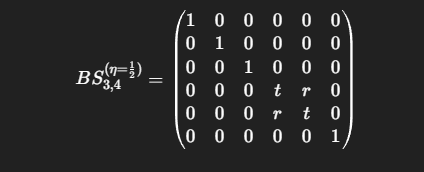

La multiplicacion de toda la red es

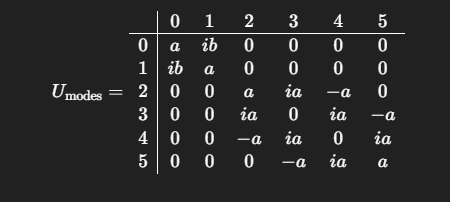

Y, escogiendo el subespacio que tiene sentido en la base computacional, tenemos que tener en cuenta la asignacion compatible con la definicion de producto tensorial:

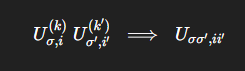

Y, al tener en cuenta que los bosones son indistinguibles (Vemos que esta parte es crucial para que la cnot funcione), tenemos que

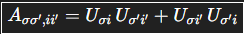

Que es la definicion de la permanente de la matriz

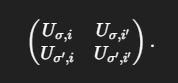

Lo que nos permite escoger los bloques de la matriz de los modos de la siguiente forma:

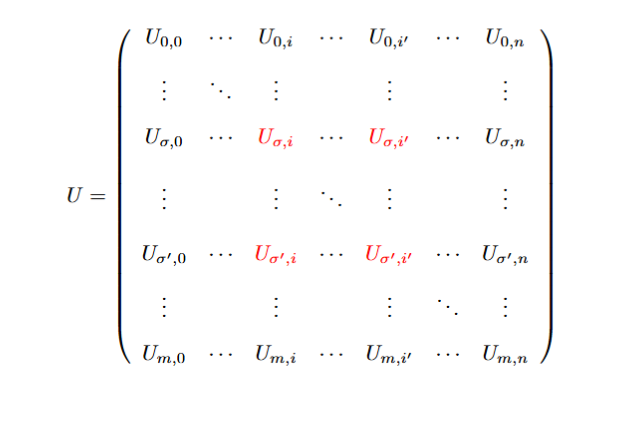

Esta forma general permite facilitar el cambio de base de caminos ópticos a base computacional up to normalization! y comprobar rapidamente si una red de caminos ópticos implementa correctamente una compuerta general!.


Explicacion del código:




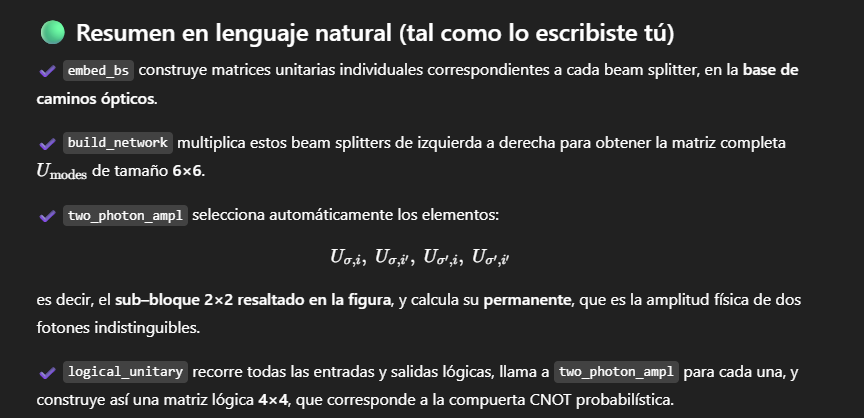

In [11]:
import numpy as np

# ============================================================
# 1) DEFINICIÓN DE LA RED DE BEAM SPLITTERS (6 MODOS)
# ============================================================

def embed_bs(U, i, j, eta, phase_r=1j):
    """
    Inserta un beam splitter lógico entre modos i y j.
    eta = fracción de potencia que no se acopla => amplitud t = sqrt(eta)
    r   = amplitud cruzada = phase_r*sqrt(1-eta)
    """
    N = U.shape[0]
    t = np.sqrt(eta)
    r = phase_r*np.sqrt(1-eta)
    BS = np.eye(N, dtype=complex)
    BS[i,i] = t
    BS[j,j] = t
    BS[i,j] = r
    BS[j,i] = r
    return BS @ U


def build_network(N, couplers):
    """
    Multiplica los BS en orden de propagación.
    U_total = BS_k ... BS_1
    """
    U = np.eye(N, dtype=complex)
    for (i,j,eta) in couplers:
        U = embed_bs(U, i, j, eta)
    return U


# ------------------------------------------------------------
# 6 MODOS (dos ancillas, control, target)
# ------------------------------------------------------------
# Mapeo lógico:
# 0 = ancilla superior
# 1 = c1   (control lógico = 1)
# 2 = c0   (control lógico = 0)
# 3 = t0
# 4 = t1
# 5 = ancilla inferior
# ------------------------------------------------------------
N = 6

# Beam Splitters según Fig. (b)
couplers = [
    (3,4, 1/2),   # BS izquierdo 50:50
    (0,1, 1/3),   # 1/3 anc_top - c1
    (2,3, 1/3),   # 1/3 c0 - t0
    (4,5, 1/3),   # 1/3 t1 - anc_bot
    (3,4, 1/2),   # BS derecho 50:50
]

U_modes = build_network(N, couplers)

print("\n=== MATRIZ FISICA U_MODES (6x6) ===")
print(np.round(U_modes,4))


# ============================================================
# 2) AMPLITUD DE 2 FOTONES (PERMANENTE 2×2)
# ============================================================

def two_photon_ampl(U, in_modes, out_modes):
    """
    A = permanente del sub-bloque 2×2:
    A = U[o1,i1]U[o2,i2] + U[o1,i2]U[o2,i1]
    """
    i1,i2 = in_modes
    o1,o2 = out_modes
    sub = np.array([
        [U[o1,i1], U[o1,i2]],
        [U[o2,i1], U[o2,i2]]
    ], dtype=complex)
    return sub[0,0]*sub[1,1] + sub[0,1]*sub[1,0]


# ============================================================
# 3) SUBESPACIO LÓGICO Y MATRIZ LÓGICA (CNOT)
# ============================================================

control = (2,1)   # c0=2, c1=1
target  = (3,4)   # t0=3, t1=4

# |00>, |01>, |10>, |11>
basis = [
    (2,3),
    (2,4),
    (1,3),
    (1,4),
]

def logical_unitary(U):
    Ulog = np.zeros((4,4), dtype=complex)
    for col, inp in enumerate(basis):
        for row, outp in enumerate(basis):
            Ulog[row,col] = two_photon_ampl(U, inp, outp)
    return Ulog

U_log = logical_unitary(U_modes)
U_CNOT = U_log / (1/3)

print("\n=== MATRIZ LÓGICA U_CNOT (normalizada) ===")
print(np.round(U_CNOT,3))


# ============================================================
# 4) ANALISIS COMPLETO DE PROBABILIDADES PARA UNA ENTRADA
# ============================================================

logical_outputs = set(basis)
ancillas = {0,5}

def analyze_two_photon_output(i1,i2):
    print("\n#############################################")
    print(f"#### ANALISIS COMPLETO DE ENTRADA física ({i1},{i2}) ####")
    print("#############################################")

    P_total = 0
    P_success = 0
    P_bunch = 0
    P_ancilla = 0
    P_other = 0

    # SOLO o1 <= o2 PARA EVITAR DUPLICADOS
    for o1 in range(6):
        for o2 in range(o1,6):

            A = two_photon_ampl(U_modes, (i1,i2), (o1,o2))
            P = np.abs(A)**2

            P_total += P   # ahora es correcto

            # Clasificación -------------------------------

            # 1) bunching
            if o1 == o2:
                if P>1e-12:
                    print(f"BUNCHING   -> salida ({o1},{o2})   P={P:.6f}")
                P_bunch += P
                continue

            # 2) salida lógica válida
            if (o1,o2) in logical_outputs or (o2,o1) in logical_outputs:
                if P>1e-12:
                    print(f"LÓGICA     -> salida ({o1},{o2})   P={P:.6f}")
                P_success += P
                continue

            # 3) ancillas
            if o1 in ancillas or o2 in ancillas:
                if P>1e-12:
                    print(f"ANCILLA    -> salida ({o1},{o2})   P={P:.6f}")
                P_ancilla += P
                continue

            # 4) otros modos
            if P>1e-12:
                print(f"OTRO       -> salida ({o1},{o2})   P={P:.6f}")
            P_other += P

    print("\n=== RESUMEN ===")
    print(f"P éxito lógico        = {P_success:.6f}")
    print(f"P bunching            = {P_bunch:.6f}")
    print(f"P ancillas            = {P_ancilla:.6f}")
    print(f"P fuera-subesp lógico = {P_other:.6f}")
    print(f"\nP TOTAL (debe ser 1)  = {P_total:.6f}")


# ============================================================
# 5) EJEMPLO: LOS CUATRO ESTADOS |00>,|01>,|10>,|11|
# ============================================================

tests = {
    "|00>": (2,3),
    "|01>": (2,4),
    "|10>": (1,3),
    "|11>": (1,4),
}

for label,(i1,i2) in tests.items():
    print(f"\n\n######## ANALISIS DE {label} ########")
    analyze_two_photon_output(i1,i2)



=== MATRIZ FISICA U_MODES (6x6) ===
[[ 0.5774+0.j      0.    +0.8165j  0.    +0.j      0.    +0.j
   0.    +0.j      0.    +0.j    ]
 [ 0.    +0.8165j  0.5774+0.j      0.    +0.j      0.    +0.j
   0.    +0.j      0.    +0.j    ]
 [ 0.    +0.j      0.    +0.j      0.5774+0.j      0.    +0.5774j
  -0.5774+0.j      0.    +0.j    ]
 [ 0.    +0.j      0.    +0.j      0.    +0.5774j  0.    +0.j
   0.    +0.5774j -0.5774+0.j    ]
 [ 0.    +0.j      0.    +0.j     -0.5774+0.j      0.    +0.5774j
   0.    +0.j      0.    +0.5774j]
 [ 0.    +0.j      0.    +0.j      0.    +0.j     -0.5774+0.j
   0.    +0.5774j  0.5774+0.j    ]]

=== MATRIZ LÓGICA U_CNOT (normalizada) ===
[[-1.+0.j  0.-0.j  0.+0.j  0.+0.j]
 [ 0.-0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+1.j]
 [ 0.+0.j  0.+0.j  0.+1.j  0.+0.j]]


######## ANALISIS DE |00> ########

#############################################
#### ANALISIS COMPLETO DE ENTRADA física (2,3) ####
#############################################
BUNCH

Y pintamos el efecto de la matriz lógica CNOT (El resultado esperado 1/9 de las veces).
En los resultados vemos que no se ve que la fase i esperada por la matriz lógica, pero esto viene de que aplicamos la traza parcial sobre el control para poder ver el efecto unicamente sobre el target, y aplicar la traza parcial se cancelan estas fases. Mas aun, es una fase global, cosa que no se ve en la esfera de bloch!


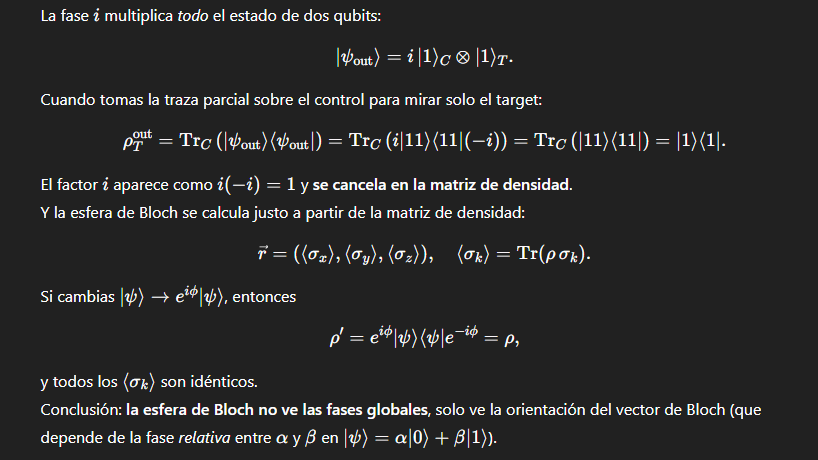

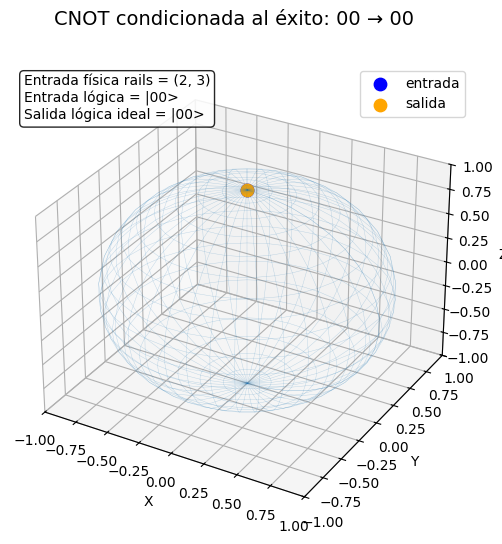

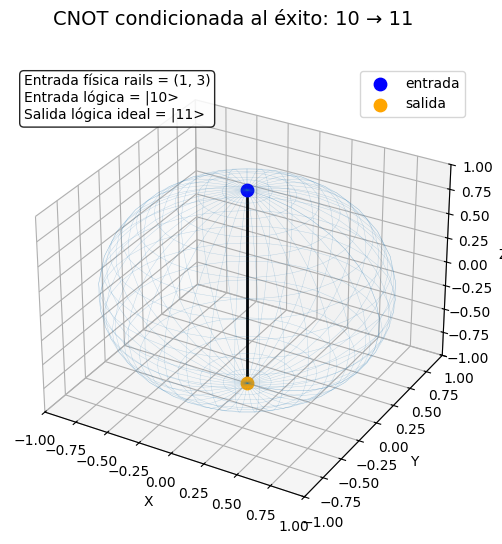

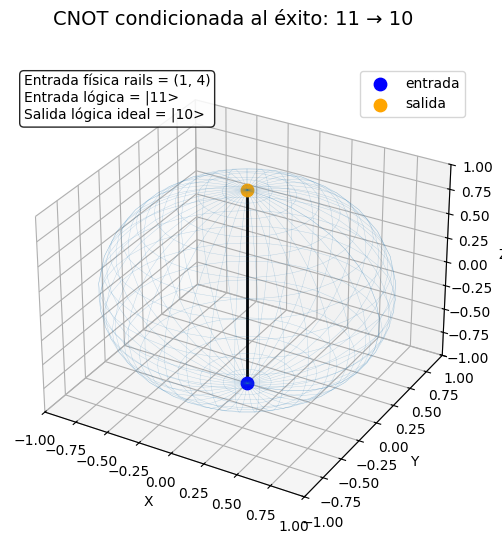

In [12]:
# ============================================================
# HERRAMIENTAS DE BLOCH
# ============================================================

sx = np.array([[0,1],[1,0]],complex)
sy = np.array([[0,-1j],[1j,0]],complex)
sz = np.array([[1,0],[0,-1]],complex)
paulis = [sx,sy,sz]

def state_to_bloch(psi):
    """Convierte un qubit puro |psi> en su vector de Bloch."""
    rho = np.outer(psi, np.conjugate(psi))
    return np.array([np.real(np.trace(rho @ p)) for p in paulis])

def plot_bloch(v_in, v_out, title, box_text):
    """Grafica entrada y salida en esfera de Bloch sin solapamiento del título."""
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection="3d")

    # --- Ajustar espacio para que no choque el título ---
    plt.subplots_adjust(top=0.88)

    # esfera
    u = np.linspace(0, 2*np.pi, 40)
    v = np.linspace(0, np.pi, 20)
    X = np.outer(np.cos(u), np.sin(v))
    Y = np.outer(np.sin(u), np.sin(v))
    Z = np.outer(np.ones_like(u), np.cos(v))
    ax.plot_wireframe(X,Y,Z,alpha=0.28,linewidth=0.3)

    # puntos
    ax.scatter(v_in[0], v_in[1], v_in[2], s=80, label="entrada", color="blue")
    ax.scatter(v_out[0], v_out[1], v_out[2], s=80, label="salida",  color="orange")

    # línea entre entrada y salida
    ax.plot([v_in[0],v_out[0]],
            [v_in[1],v_out[1]],
            [v_in[2],v_out[2]], color="black", lw=2)

    # --- Caja movida más abajo para evitar choque con el título ---
    ax.text2D(0.03, 0.88, box_text, transform=ax.transAxes,
              bbox=dict(boxstyle="round", facecolor="white", alpha=0.85))

    # ejes y límites
    ax.set_xlim([-1,1]); ax.set_ylim([-1,1]); ax.set_zlim([-1,1])
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")

    # --- Título ligeramente más arriba ---
    fig.suptitle(title, fontsize=14, y=0.97)

    ax.legend()
    plt.show()

# ============================================================
# MAPEO RAILS → ESTADOS LÓGICOS
# ============================================================

logical_basis = {
    (2,3): np.array([1,0,0,0], complex),  # |00>
    (2,4): np.array([0,1,0,0], complex),  # |01>
    (1,3): np.array([0,0,1,0], complex),  # |10>
    (1,4): np.array([0,0,0,1], complex),  # |11>
}

label_map = {
    (2,3): "00",
    (2,4): "01",
    (1,3): "10",
    (1,4): "11",
}

ideal_map = {
    "00": "00",
    "01": "01",
    "10": "11",
    "11": "10",
}

def rails_to_label(rails):
    """Devuelve '00','01','10','11' según los rails físicos."""
    if rails in label_map:
        return label_map[rails]
    raise ValueError(f"Rails {rails} no pertenecen al subespacio lógico.")


# ============================================================
# FUNCIÓN PRINCIPAL
# ============================================================

def plot_cnot_bloch_from_rails(rails_in, U_CNOT):
    """
    rails_in = (c,t) modos donde entran los dos fotones.
    U_CNOT = matriz lógica 4x4 condicionada al éxito.
    """

    # --- estado lógico de entrada
    psi_in = logical_basis[rails_in]

    # --- estado lógico de salida
    psi_out = U_CNOT @ psi_in
    psi_out = psi_out / np.linalg.norm(psi_out)

    # --- determinar qubits reducidos
    label_in = rails_to_label(rails_in)
    label_out = ideal_map[label_in]

    # reducer al qubit target
    if label_in[0] == "0":
        q_in  = np.array([1,0],complex) if label_in[1]=="0" else np.array([0,1],complex)
        q_out = np.array([1,0],complex) if label_out[1]=="0" else np.array([0,1],complex)
    else:
        q_in  = np.array([1,0],complex) if label_in[1]=="0" else np.array([0,1],complex)
        q_out = psi_out[2:] / np.linalg.norm(psi_out[2:])

    # vectores Bloch
    b_in  = state_to_bloch(q_in)
    b_out = state_to_bloch(q_out)

    box = f"Entrada física rails = {rails_in}\nEntrada lógica = |{label_in}>\nSalida lógica ideal = |{label_out}>"

    plot_bloch(
        b_in, b_out,
        title=f"CNOT condicionada al éxito: {label_in} → {label_out}",
        box_text=box
    )

plot_cnot_bloch_from_rails((2,3), U_CNOT)   # |00> → |00>
plot_cnot_bloch_from_rails((1,3), U_CNOT)   # |10> → |11>
plot_cnot_bloch_from_rails((1,4), U_CNOT)   # |11> → |10>


Ahora, calculamos el efecto del arreglo no sobre algo de la forma $\hat{a_C}^\dagger \hat{A_T}^\dagger\ket{\psi} $, sino de la forma $\hat{A_C}^\dagger \hat{A_T}^\dagger\ket{\psi}$, es decir, teniendo en cuenta la distribucion espectral. Esta parte no es muy interesante teniendo en cuenta que los BS no son fuertemente dispersivos. Es decir:
Cada fuente genera un par señal–idler en la base de Schmidt:

$$
|\Psi_{\text{source}}\rangle
=
\sum_i \sqrt{\lambda_i}\,
\hat A^{(i)\dagger}_s\,
\hat B^{(i)\dagger}_i\,|0\rangle.
$$

Los operadores de creación espectrales vienen dados por

$$
\hat A^{(i)\dagger}_s
=
\int d\omega_s\,\phi_i(\omega_s)\,\hat a_s^\dagger(\omega_s),
\qquad
\hat B^{(i)\dagger}_i
=
\int d\omega_i\,\Omega_i(\omega_i)\,\hat a_i^\dagger(\omega_i).
$$

---

Al trazar el idler se obtiene el estado espectral de la señal:

$$
\hat\rho_s
=
\mathrm{Tr}_i\bigl(|\Psi_{\text{source}}\rangle\langle\Psi_{\text{source}}|\bigr)
=
\sum_i \lambda_i\,|\phi_i\rangle\langle\phi_i|,
$$

donde

$$
|\phi_i\rangle
=
\int d\omega_s\,\phi_i(\omega_s)\,\hat a_s^\dagger(\omega_s)|0\rangle .
$$

---

En el caso ideal suponemos un único modo de Schmidt:

$$
\lambda_1 = 1,
$$

y la señal en un estado puro con distribución gaussiana:

$$
A(\omega) = \phi_1(\omega).
$$

Entonces la señal se escribe como:

$$
|\phi\rangle
=
\int d\omega\, A(\omega)\,\hat a^\dagger(\omega)\,|0\rangle.
$$

---

Usamos dos fuentes idénticas.  
Después de descartar los idlers, cada una aporta una señal con el MISMO perfil espectral \(A(\omega)\).  
Por tanto, los operadores que entran en los modos de control y target son:

$$
\hat A_C^\dagger
=
\int d\omega\,A(\omega)\,\hat a_C^\dagger(\omega),
\qquad
\hat A_T^\dagger
=
\int d\omega\,A(\omega)\,\hat a_T^\dagger(\omega).
$$

El estado de entrada al chip CNOT es:

$$
|\Psi_{\text{in}}\rangle
=
\left( \hat A_C^\dagger \right)
\left( \hat A_T^\dagger \right)
|0\rangle.
$$

---

La unitaria del chip aplica la transformación:

$$
\hat a_j^\dagger(\omega)
\longrightarrow
\sum_m U_{mj}\,\hat a_m^\dagger(\omega),
$$

asumiendo que \(U_{mj}\) no depende de \(\omega\).

Así, la evolución de los operadores modales es:

$$
\hat U\,\hat A_C^\dagger\,\hat U^\dagger
=
\sum_m U_{mc}\,\hat A_m^\dagger,
\qquad
\hat U\,\hat A_T^\dagger\,\hat U^\dagger
=
\sum_n U_{nt}\,\hat A_n^\dagger,
$$

donde

$$
\hat A_m^\dagger
=
\int d\omega\,A(\omega)\,\hat a_m^\dagger(\omega).
$$

---

El estado de salida del chip es:

$$
|\Psi_{\text{out}}\rangle
=
\left(\sum_m U_{mc}\,\hat A_m^\dagger\right)
\left(\sum_n U_{nt}\,\hat A_n^\dagger\right)
|0\rangle.
$$

Es decir:

$$
|\Psi_{\text{out}}\rangle
=
\sum_{m,n}
U_{mc}U_{nt}\,
\hat A_m^\dagger \hat A_n^\dagger\,|0\rangle.
$$

---

Dado que ambas señales comparten el mismo perfil espectral \(A(\omega)\)  
y la unitaria \(U\) es acromática, el espectro *se factoriza* y:

- **NO altera las amplitudes espaciales**, y  
- **NO cambia las probabilidades de scattering**, que siguen dadas por permanentes:

$$
\mathrm{Perm}\begin{pmatrix}
U_{o_1,i_1} & U_{o_1,i_2} \\
U_{o_2,i_1} & U_{o_2,i_2}
\end{pmatrix}.
$$

Por tanto, el modelo espectral continuo es perfectamente consistente con el cálculo discreto sobre la matriz \(U\) de 6×6 modos.


Lumerical Directional Couplers

In [20]:
import h5py
import numpy as np
import pandas as pd

# ----------------------------------------------------------
# FUNCIÓN PARA MOSTRAR LA ESTRUCTURA DEL ARCHIVO
# ----------------------------------------------------------
def print_structure(name, obj):
    if isinstance(obj, h5py.Dataset):
        print(f"[DATASET] {name} -> shape={obj.shape}, dtype={obj.dtype}")
    elif isinstance(obj, h5py.Group):
        print(f"[GROUP] {name}")


ruta = "C:/Users/ekkol/Downloads/Reto_Fot-nica/Reto/Datos_reto/Datos_gap.h5"

# ----------------------------------------------------------
# LEER ARCHIVO H5
# ----------------------------------------------------------
with h5py.File(ruta, "r") as h5:

    print("=== ESTRUCTURA DEL ARCHIVO ===")
    h5.visititems(print_structure)

    # Leer el dataset A: ahora shape = (3, 3, N_gaps)
    data = h5["A"][:]
    print("\nContenido bruto del dataset 'A':\n", data)

# ----------------------------------------------------------
# PROCESAR: A[0,:,:] = gaps, A[1,:,:] = n1, A[2,:,:] = n2
# ----------------------------------------------------------
A = data  # shape (3, 3, N_gaps)

# valores de gap: tomo la fila 0, λ_p (índice 0) para todos los gaps
gap_vals = A[0, 0, :]              # shape (N_gaps,)

# n1(λ, gap) y n2(λ, gap)
n1 = A[1, :, :]                    # shape (3 lambdas, N_gaps)
n2 = A[2, :, :]                    # shape (3 lambdas, N_gaps)

dn = n1 - n2                       # shape (3 lambdas, N_gaps)

# ----------------------------------------------------------
# DATAFRAME: filas λ_p, λ_s, λ_i ; columnas por gap
# ----------------------------------------------------------
col_names = [f"Gap_{g:.3f}" for g in gap_vals]

df = pd.DataFrame(
    dn,
    index=[r"λ_p", r"λ_s", r"λ_i"],
    columns=col_names
)

print("\n=== DATAFRAME FINAL (n1 - n2 por λ y gap) ===\n")
print(df)


=== ESTRUCTURA DEL ARCHIVO ===
[DATASET] A -> shape=(3, 3, 5), dtype=float64

Contenido bruto del dataset 'A':
 [[[0.4        0.525      0.65       0.775      0.9       ]
  [0.4        0.525      0.65       0.775      0.9       ]
  [0.4        0.525      0.65       0.775      0.9       ]]

 [[1.83344473 1.83348721 1.83349147 1.83326091 1.833437  ]
  [1.8117803  1.8117664  1.81175606 1.81165769 1.81171285]
  [1.51462525 1.51052644 1.50805018 1.5065757  1.50534181]]

 [[1.83342956 1.83348516 1.8334912  1.83326083 1.833437  ]
  [1.81164564 1.81173272 1.81174737 1.81165536 1.81171223]
  [1.49170326 1.49591053 1.49850776 1.5001847  1.5010483 ]]]

=== DATAFRAME FINAL (n1 - n2 por λ y gap) ===

     Gap_0.400  Gap_0.525     Gap_0.650     Gap_0.775     Gap_0.900
λ_p   0.000015   0.000002  2.662542e-07  7.731605e-08  4.551461e-09
λ_s   0.000135   0.000034  8.684356e-06  2.327276e-06  6.186264e-07
λ_i   0.022922   0.014616  9.542426e-03  6.390997e-03  4.293508e-03


In [ ]:
import numpy as np

import pandas as pd

# =====================================================
# 1. TUS LAMBDAS
# =====================================================
lam_p_um = 0.82304440579
lam_s_um = 1.5616689
lam_i_um = 0.5587644

lam_vec = np.array([lam_p_um, lam_s_um, lam_i_um])  # [λp, λs, λi]

# =====================================================
# 2. FUNCIÓN PARA CALCULAR Lc
# =====================================================
def Lc(lambda_um, dn):
    return lambda_um / (2 * dn)

# =====================================================
# 3. A PARTIR DEL DATAFRAME df (QUE YA EXISTE)
# =====================================================
# df es algo así:
#
#              gap_1      gap_2     gap_3
# λ_p      dn_p_gap1  dn_p_gap2 ...
# λ_s      dn_s_gap1  dn_s_gap2 ...
# λ_i      dn_i_gap1  dn_i_gap2 ...
#

gaps = list(df.columns)
num_gaps = len(gaps)

# Matriz Lc: filas = λp, λs, λi; columnas = gaps
Lc_mat = np.zeros((3, num_gaps))

for j, gap in enumerate(gaps):
    for i, lam in enumerate(lam_vec):
        dn = df.loc[df.index[i], gap]
        Lc_mat[i, j] = Lc(lam, dn)

df_Lc = pd.DataFrame(
    Lc_mat,
    index=["L_cp", "L_cs", "L_ci"],
    columns=gaps
)

print("\n=== Longitudes de Acoplamiento (Lc) ===")
print(df_Lc)

# =====================================================
# 4. BUSQUEDA DE L ÓPTIMO CON PARIDADES
# =====================================================
epsilon = 0.5    # tolerancia
Kmax = 1000         # máximo múltiplo buscado

def buscar_L_opt(Lcp, Lcs, Lci):
    soluciones = []
    for Kp in range(1, Kmax, 2):      # pump → impar
        for Ks in range(0, Kmax, 2):  # signal → par
            for Ki in range(0, Kmax, 2):  # idler → par
                
                Lp = Kp * Lcp
                Ls = Ks * Lcs
                Li = Ki * Lci

                # misma longitud dentro del error relativo
                if abs(Lp - Ls) < epsilon*Lcp and abs(Lp - Li) < epsilon*Lcp:
                    soluciones.append((Lp, Kp, Ks, Ki))

    if len(soluciones) == 0:
        return np.nan
    else:
        return soluciones[0][0]   # devolvemos el primer match

# Para cada gap…
Lopt_list = []

for j in range(num_gaps):
    Lcp = Lc_mat[0, j]
    Lcs = Lc_mat[1, j]
    Lci = Lc_mat[2, j]

    Lopt = buscar_L_opt(Lcp, Lcs, Lci)
    Lopt_list.append(Lopt)

df_Lopt = pd.DataFrame(
    [Lopt_list],
    index=["L_optimo_total"],
    columns=gaps
)

print("\n=== L Óptimo para cada gap ===")
print(df_Lopt)

# =====================================================
# 5. TABLA FINAL
# =====================================================
df_final = pd.concat([df_Lc, df_Lopt])
print("\n=== TABLA FINAL ===")
print(df_final)



=== Longitudes de Acoplamiento (Lc) ===
        Gap_0.200     Gap_0.300
L_cp  1337.535432  11143.578433
L_cs   589.784089   1869.659746
L_ci     5.912270      8.341413

=== L Óptimo para cada gap ===
                  Gap_0.200     Gap_0.300
L_optimo_total  1337.535432  11143.578433

=== TABLA FINAL ===
                  Gap_0.200     Gap_0.300
L_cp            1337.535432  11143.578433
L_cs             589.784089   1869.659746
L_ci               5.912270      8.341413
L_optimo_total  1337.535432  11143.578433
